In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from anytree import Node, RenderTree
%matplotlib widget

In [95]:
def add_nodes(nodes, parent, child, grandchild, ggchild):
    if parent not in nodes:
        nodes[parent] = Node(parent)  
    if child not in nodes:
        nodes[child] = Node(child)
    if grandchild not in nodes:
        nodes[grandchild] = Node(grandchild)
    if ggchild not in nodes:
        nodes[ggchild] = Node(ggchild)
    nodes[child].parent = nodes[parent]
    nodes[grandchild].parent = nodes[child]
    nodes[ggchild].parent = nodes[grandchild]

In [22]:
df_y_train = pd.read_csv('./y_train_JQU4vbI.csv')
df_x_train = pd.read_csv('./x_train_Lafd4AH.csv')

Here we have market data over 20 days. Colums RET_1,...,RET_20 are the residual stock returns in those 20 days. The column DATE is a date index, however, it is randomized and has no continuity

In [144]:
print(df_x_train)

            ID  DATE  STOCK  INDUSTRY  INDUSTRY_GROUP  SECTOR  SUB_INDUSTRY  \
0            0     0      2        18               5       3            44   
1            1     0      3        43              15       6           104   
2            2     0      4        57              20       8           142   
3            3     0      8         1               1       1             2   
4            4     0     14        36              12       5            92   
...        ...   ...    ...       ...             ...     ...           ...   
418590  418590   223   5703        32              10       4            77   
418591  418591   223   5705        35              12       5            91   
418592  418592   223   5709         2               1       1             5   
418593  418593   223   5710        33              10       4            83   
418594  418594   223   5713        26               7       4            60   

           RET_1  VOLUME_1     RET_2  ...    RET_16

In [96]:
df = df_x_train#[['DATE','ID','INDUSTRY','INDUSTRY_GROUP',*[col for col in cols if 'RET_' in col]]]

df = df[df['DATE']==0]
nodes = {}  # store references to created nodes 
# data.apply(lambda x: add_nodes(nodes, x["Parent"], x["Child"]), axis=1)  # 1-liner
for parent, child, grandchild, ggchild in zip(df["SECTOR"],(df["INDUSTRY_GROUP"]),(df["INDUSTRY"]),df["SUB_INDUSTRY"]):
    #print(parent, child)
    add_nodes(nodes, parent, 'Industry group '+str(child),'Industry '+str(grandchild), 'Sub industry '+str(ggchild))

#roots = list(df[~df["INDUSTRY"].isin(df["INDUSTRY_GROUP"])]["INDUSTRY"].unique())
roots = np.unique(df[['SECTOR']].T.values[0,:])
for root in roots:         # you can skip this for roots[0], if there is no forest and just 1 tree
    for pre, _, node in RenderTree(nodes[root]):
        print("%s%s" % (pre, node.name))
print(roots)

0
└── Industry group 0
    └── Industry 0
        └── Sub industry 0
1
└── Industry group 1
    ├── Industry 1
    │   ├── Sub industry 2
    │   └── Sub industry 1
    └── Industry 2
        ├── Sub industry 4
        ├── Sub industry 6
        ├── Sub industry 3
        ├── Sub industry 5
        └── Sub industry 7
2
└── Industry group 2
    ├── Industry 6
    │   ├── Sub industry 17
    │   ├── Sub industry 22
    │   ├── Sub industry 19
    │   ├── Sub industry 20
    │   └── Sub industry 16
    ├── Industry 3
    │   ├── Sub industry 12
    │   ├── Sub industry 8
    │   ├── Sub industry 9
    │   ├── Sub industry 11
    │   └── Sub industry 10
    ├── Industry 4
    │   └── Sub industry 13
    ├── Industry 7
    │   ├── Sub industry 24
    │   └── Sub industry 23
    └── Industry 5
        ├── Sub industry 14
        └── Sub industry 15
3
├── Industry group 5
│   ├── Industry 18
│   │   └── Sub industry 44
│   ├── Industry 20
│   │   ├── Sub industry 46
│   │   └── Sub industry 4

In [163]:
rets = [col for col in df_day_0.columns if 'RET_' in col]
df_x_train[df_x_train['DATE']==0].groupby('INDUSTRY')[[*rets]].shift(1)

,RET_1,RET_2,RET_3,RET_4,RET_5,RET_6,RET_7,RET_8,RET_9,RET_10,RET_11,RET_12,RET_13,RET_14,RET_15,RET_16,RET_17,RET_18,RET_19,RET_20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2372,-0.002498,0.005021,-0.001254,0.000000,0.015924,0.019480,0.011827,-0.011689,0.013158,0.021505,-0.014569,0.013423,-0.009308,0.009396,-0.022951,0.021433,-0.006653,0.018983,-0.024471,0.039175
2373,-0.011389,-0.007910,-0.016666,-0.032258,-0.010638,0.000000,-0.005291,0.010695,0.015201,-0.026530,-0.002004,0.111501,NaN,NaN,NaN,0.000000,0.024362,-0.017551,-0.023918,0.028489
2374,-0.025779,-0.013131,0.001233,-0.004906,-0.005691,0.018634,-0.008621,0.006611,-0.005752,0.006201,0.001656,-0.014286,-0.003660,0.014021,-0.012220,0.025481,-0.002501,0.000000,-0.010717,0.006639
2375,0.059536,-0.040194,0.022784,0.014572,0.024189,0.009350,-0.020356,-0.004559,0.058445,0.032097,-0.017935,0.006564,-0.010286,0.004896,-0.011828,0.012520,-0.002714,-0.004862,0.011476,0.026936


(90, 20)
9.072136453945186


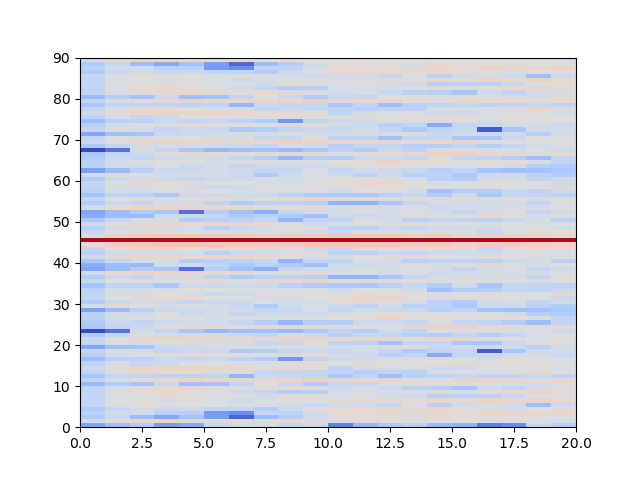

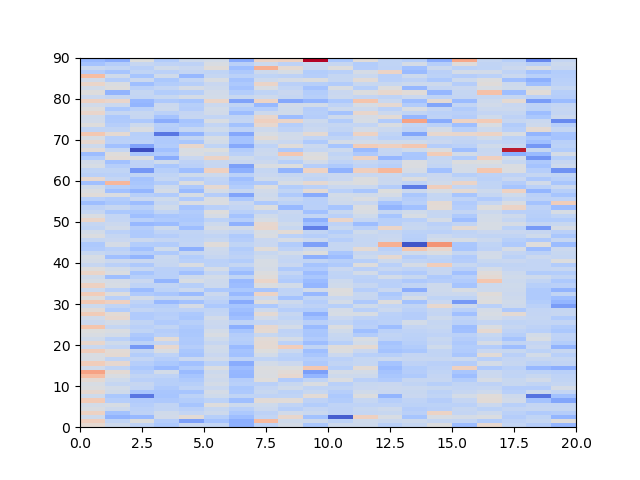

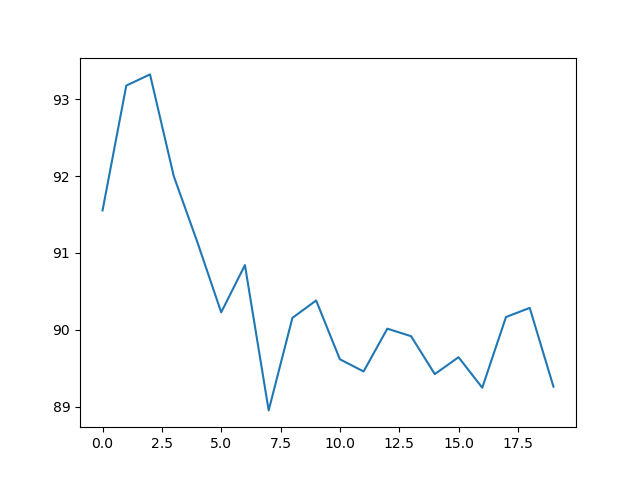

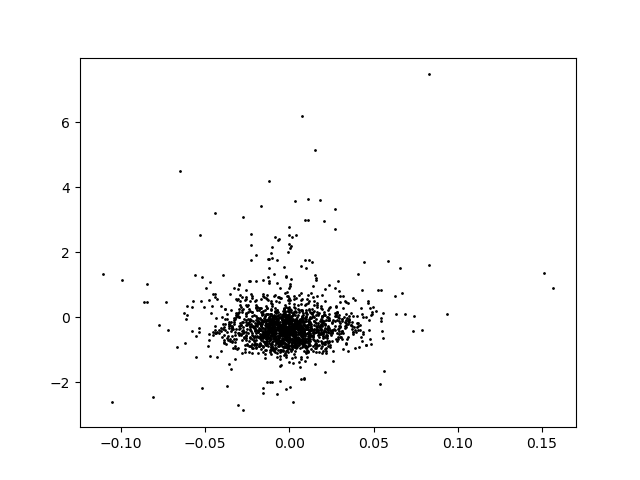

In [24]:
df_day_0 = df_x_train[df_x_train['DATE'] == 0].dropna()
df_day_0 = df_day_0[df_day_0['SECTOR'] == 1]
rets = [col for col in df_day_0.columns if 'RET_' in col]
vols = [col for col in df_day_0.columns if 'VOLUME_' in col]
rets = df_day_0[rets].to_numpy()
vols = df_day_0[vols].to_numpy()
p0 = 1
prices = np.zeros_like(rets) 
prices[:,0] = p0*(rets[:,0]+1)
for jj in range(rets[0,:].size-1):
    prices[:,jj+1] = prices[:,jj]*(rets[:,jj]+1)
print(rets.shape)
plt.close('all')
fig, ax = plt.subplots()
ax.pcolormesh(np.fft.fftshift(np.log(abs(np.fft.fft(prices,axis=0))**2),axes=0),rasterized=True,vmax=8,cmap='coolwarm')
print(np.fft.fftshift(np.log(abs(np.fft.fft(prices,axis=0))**2),axes=0).max())
fig, ax = plt.subplots()
ax.pcolormesh((rets),rasterized=True,cmap='coolwarm')
fig, ax = plt.subplots()
ax.plot(np.sum(prices,axis=0))

fig,ax = plt.subplots()
for jj in range(prices[:,0].size):
    ax.scatter(rets[jj,:],vols[jj,:],c='k',s=1.0)

In [124]:
cols = df_x_train.columns
df = df_x_train#[['DATE','ID','INDUSTRY','INDUSTRY_GROUP',*[col for col in cols if 'RET_' in col]]]

df = df[df['DATE']==4]

#df = df[df['INDUSTRY']==37]
print(df)
#df = df[df['INDUSTRY_GROUP']==5]
df = df[df['SUB_INDUSTRY']==142]
prices = df[[*[col for col in cols if 'RET_'in col]]]
prices = prices.to_numpy()
vols = df[[*[col for col in cols if 'VOLUME_'in col]]]
vols = vols.to_numpy()
print(vols)
corr = [] 
corr_price_volume =[]
for ii in range(prices.shape[0]):
    corr_price_volume+=[np.correlate(prices[ii,:],vols[ii,:])]
    for jj in range(ii+1, prices.shape[0],1):
        corr += [np.correlate(prices[ii,:],prices[jj,:])]
#print(prices)
#print(prices.corr(numeric_only=True))
#[print(col) for col in cols if 'RET_' in col]


        ID  DATE  STOCK  INDUSTRY  INDUSTRY_GROUP  SECTOR  SUB_INDUSTRY  \
5198  5198     4      0        37              12       5            94   
5199  5199     4      1        15               4       3            37   
5200  5200     4      4        57              20       8           142   
5201  5201     4      5        35              12       5            91   
5202  5202     4      6        57              20       8           142   
...    ...   ...    ...       ...             ...     ...           ...   
8012  8012     4   5710        33              10       4            83   
8013  8013     4   5713        26               7       4            60   
8014  8014     4   5714        49              17       7           113   
8015  8015     4   5715        59              21       8           145   
8016  8016     4   5716        50              17       7           114   

         RET_1  VOLUME_1     RET_2  ...    RET_16  VOLUME_16    RET_17  \
5198  0.001348 -0.269520 

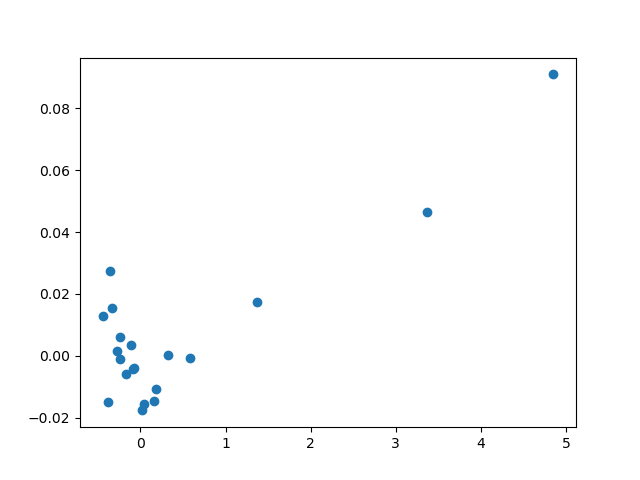

In [129]:
plt.close('all')
fig, ax = plt.subplots()
#ax.plot((corr),'.')
#ax.plot((corr_price_volume),'.')
#ax.plot(vols[1,:])
ax.scatter(vols[1,:],prices[1,:])

In [89]:
np.unique(df[['SECTOR']].T.values[0,:])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

AttributeError: 'DataFrame' object has no attribute 'data'

In [92]:
print(df_x_train)
print(df_x_train['STOCK'][:2377])
print(df_x_train['DATE'][2377:2*2377+445])

            ID  DATE  STOCK  INDUSTRY  INDUSTRY_GROUP  SECTOR  SUB_INDUSTRY  \
0            0     0      2        18               5       3            44   
1            1     0      3        43              15       6           104   
2            2     0      4        57              20       8           142   
3            3     0      8         1               1       1             2   
4            4     0     14        36              12       5            92   
...        ...   ...    ...       ...             ...     ...           ...   
418590  418590   223   5703        32              10       4            77   
418591  418591   223   5705        35              12       5            91   
418592  418592   223   5709         2               1       1             5   
418593  418593   223   5710        33              10       4            83   
418594  418594   223   5713        26               7       4            60   

           RET_1  VOLUME_1     RET_2  ...    RET_16

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 2.00000e+00, 2.00000e+00,
        1.00000e+00, 4.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00, 3.00000e+00,
        2.00000e+00, 2.00000e+00, 4.00000e+00, 2.00000e+00, 8.00000e+00,
        6.00000e+00, 6.00000e+00, 6.00000e+00, 2.00000e+00, 4.00000e+00,
        4.00000e+00, 4.00000e+00, 7.00000e+00, 1.30000e+01, 1.60000e+01,
        2.30000e+01, 1.40000e+01, 1.90000e+01, 2.20000e+01, 2.60000e+01,
        3.50000e+01, 4.70000e+01, 6.80000e+01, 8.80000e+01, 1.13000e+02,
        1.60000e+02, 1.86000e+02, 2.80000e+02, 3.84000e+02, 5.65000e+02,
        9.15000e+02, 1.36400e+03, 2.33600e+03, 3.84

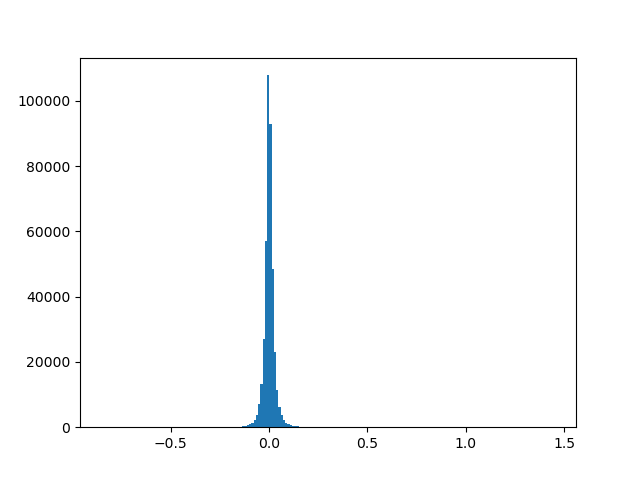

In [40]:
fig, ax = plt.subplots()
ax.hist(df_x_train['RET_1'],bins=200)

In [21]:
#df_x_train["RET_1"].shape

(418595,)

In [ ]:
|